In [ ]:
!pip install -q tensorflow-recommenders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import string # for string manipulation operations
import re # for regular expression operations n.

import pandas as pd #for data manipulation and analysis
import numpy as np #for numerical computing
import seaborn as sns #for data visualization
import matplotlib.pyplot as plt #for data visualization
import tensorflow as tf #for building and training deep learning models
import tensorflow_recommenders as tfrs #as a high-level API for building recommendation models on top of TensorFlow
from collections import Counter #for counting occurrences of elements in a list or other iterable
from typing import Dict, Text #for declaring data types in a function or module
from ast import literal_eval #for evaluating strings as code
from datetime import datetime #for working with dates and times
from wordcloud import WordCloud #for generating word clouds from text
from sklearn.preprocessing import MinMaxScaler #for feature scaling
from sklearn.feature_extraction.text import TfidfVectorizer #for converting text into numerical features
from sklearn.metrics.pairwise import cosine_similarity #for measuring similarity between two non-zero vectors of an inner product space.
import random #To generate random numbers to select random movies for user to rate

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Import the required datasets
credits = pd.read_csv('/content/drive/MyDrive/movies/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/movies/keywords.csv')
movies = pd.read_csv('/content/drive/MyDrive/movies/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')
#Merge all the datasets together
df = movies.merge(keywords, on='id').merge(credits, on='id')
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [ ]:
#Fill in the missing values
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
#A function to extract the useful information from the columns
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

#Applying the functions to the columns
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

#Create new columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [ ]:
#Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [ ]:
#Changing the datatype of certain columns
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [ ]:
#Here, I am choosing movies released after 2009 and which were originally shot in English
df = df[df['release_date'].dt.year>2009]
df = df[df['original_language']=='en']
df = df.reset_index()

In [ ]:
#Total number of movies after filtering
df.shape

(8243, 22)

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

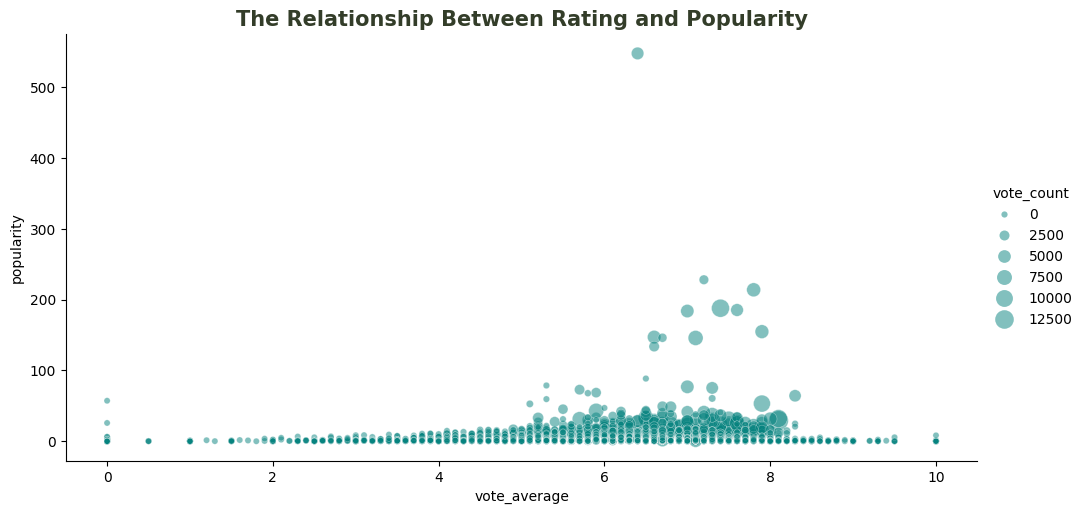

In [ ]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

In [ ]:
#Importing the dataset of the ratings
ratings_df = pd.read_csv('/content/drive/MyDrive/movies/ratings.csv')

#Changing the datatype of the 'date' column
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

#Adding the columns from the merged dataset
ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)
ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,7,88744,1.5,2017-02-05 00:19:34,Die Frau mit den 5 Elefanten,"Documentary, Foreign","Documentary about Svetlana Geier, a Ukranian w..."
1,11,47518,3.0,2009-01-11 12:08:08,The Tortured,Horror,An upper-middle-class couple's life is destroy...
2,11,49530,3.5,2009-01-11 12:24:52,In Time,"Action, Thriller, Science Fiction",In the not-too-distant future the aging gene h...
3,11,50601,2.5,2009-01-11 13:02:10,5 Days of War,"War, Drama",An American journalist and his cameraman are c...
4,11,51540,4.0,2009-01-11 12:21:47,Horrible Bosses,"Comedy, Crime","For Nick, Kurt and Dale, the only thing that w..."


In [ ]:
#Selecting the id and title column of the merged dataframe
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,79782,Wenecja
1,141210,The Sleepover
2,143750,The Farmer's Wife
3,84198,A Place at the Table
4,171982,Romance


In [ ]:
#Selecting the UserId, title, and rating from the ratings dataframe
ratings_df = ratings_df[['userId', 'original_title', 'rating']]
ratings_df.head()

,userId,original_title,rating
0,7,Die Frau mit den 5 Elefanten,1.5
1,11,The Tortured,3.0
2,11,In Time,3.5
3,11,5 Days of War,2.5
4,11,Horrible Bosses,4.0


In [ ]:
#Resetting the index of the movies dataframe
movies_df = movies_df.reset_index()
movies_df.head()

,index,movieId,original_title
0,0,79782,Wenecja
1,1,141210,The Sleepover
2,2,143750,The Farmer's Wife
3,3,84198,A Place at the Table
4,4,171982,Romance


In [ ]:
#Resetting the index of the merged dataframe
df = df.reset_index()
df.head()
del df['level_0']

In [ ]:
#Sorting by popularity to let the user rate the most popular ones
pdf = df.sort_values('popularity', ascending=False)
pdf = pdf.reset_index()
pdf.head()

,level_0,index,adult,budget,genres,id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,4194,28982,False,74000000.0,"Family, Animation, Adventure, Comedy",211672,en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,...,1.156731e+09,91.0,English,"Before Gru, they had a history of bad bosses",6.4,4729.0,"assistant, aftercreditsstinger, duringcreditss...","Christopher Meledandri, Kyle Balda, Ken Daurio...","Scarlet Overkill (voice), Herb Overkill (voice...","Sandra Bullock, Jon Hamm, Michael Keaton, Alli..."
1,7837,40726,False,34000000.0,"Action, Crime",339403,en,Baby Driver,After being coerced into working for a crime b...,228.032744,...,2.245113e+08,113.0,English,All you need is one killer track.,7.2,2083.0,"robbery, atlanta, music, crime boss, romance, ...","Edgar Wright, Edgar Wright, Tim Bevan, James B...","Baby, Deborah, Doc, Bats, Buddy, Darling, Jose...","Ansel Elgort, Lily James, Kevin Spacey, Jamie ..."
2,2752,23304,False,165000000.0,"Adventure, Family, Animation, Action, Comedy",177572,en,Big Hero 6,The special bond that develops between plus-si...,213.849907,...,6.521054e+08,102.0,English,From the creators of Wreck-it Ralph and Frozen,7.8,6289.0,"brother brother relationship, hero, talent, re...","John Lasseter, Robert Richardson, Mark Henley,...","Baymax (voice), Hiro Hamada (voice), Tadashi H...","Scott Adsit, Ryan Potter, Daniel Henney, T.J. ..."
3,3270,25206,False,58000000.0,"Action, Adventure, Comedy",293660,en,Deadpool,Deadpool tells the origin story of former Spec...,187.860492,...,7.831130e+08,108.0,English,Witness the beginning of a happy ending,7.4,11444.0,"anti hero, mercenary, marvel comic, superhero,...","Robert Alonzo, Tim Miller, Rhett Reese, Paul W...","Wade Wilson / Deadpool, Vanessa Carlysle / Cop...","Ryan Reynolds, Morena Baccarin, Ed Skrein, T.J..."
4,3272,25208,False,200000000.0,"Action, Adventure, Comedy, Science Fiction",283995,en,Guardians of the Galaxy Vol. 2,The Guardians must fight to keep their newfoun...,185.330992,...,8.634161e+08,137.0,English,Obviously.,7.6,4858.0,"sequel, superhero, based on comic, misfit, spa...","Lisa J. Levine, Jason C. Lewis, Lora Hirschber...","Peter Quill / Star-Lord, Gamora, Drax the Dest...","Chris Pratt, Zoe Saldana, Dave Bautista, Vin D..."


In [ ]:
#Random number generation for the user to rate movies out of 5
user_id = 270897
m = 3
randomList = []
for i in range(10):
    r=random.randint(1,10)
    if r not in randomList:
        randomList.append(r)

print("Welcome")
name = input("Enter your name:")

for i in randomList:
    movie = pdf['original_title'][i]
    print(i)

    movie_row = pdf[pdf['original_title'] == movie]
    print()
    print(movie)
    print("Overview: ", pdf[pdf['original_title'] == movie]['overview'][i])
    print("Cast: ", pdf[pdf['original_title'] == movie]['actors'][i])
    user_r = input('Enter your rating out of 5 (Enter dk if you dont know the movie)')
    if(user_r=='dk'):
        continue;
    else:
        user_r = int(user_r)
        new_row = pd.DataFrame([{'userId':user_id, 'original_title':movie, 'rating':user_r}])
        ratings_df = pd.concat([ratings_df, new_row], ignore_index=True)

Welcome
Enter your name:Ayush 
2

Big Hero 6
Overview:  The special bond that develops between plus-sized inflatable robot Baymax, and prodigy Hiro Hamada, who team up with a group of friends to form a band of high-tech heroes.
Cast:  Scott Adsit, Ryan Potter, Daniel Henney, T.J. Miller, Jamie Chung, Damon Wayans Jr., Génesis Rodríguez, James Cromwell, Alan Tudyk, Maya Rudolph, Abraham Benrubi, Katie Lowes, Billy Bush, Daniel Gerson, Paul Briggs, Charlie Adler, Marcella Lentz-Pope, David Shaughnessy, Cam Clarke, Nicholas Guest, Terri Douglas, Tim Mertens, Yuri Lowenthal, Sundra Oakley, Brian R. Norris, Stan Lee, Shane Sweet, Frank Welker, David Cowgill, Kirk Baily, Charlotte Gulezian, Reed Buck, Roy Conli, Cooper Cowgill, Jackie Gonneau, Marlie Crisafulli, Bridget Hoffman, Kelly Hoover, Leah Latham, James Taku Leung, Yumi Mizui, Michael Powers, Lynwood Robinson, Josie Trinidad, Dan Howell, June Christopher
Enter your rating out of 5 (Enter dk if you dont know the movie)5
10

Pirates of

In [ ]:
#Changing the datatype to string
ratings_df['userId'] = ratings_df['userId'].astype(str)

#Creating data for the model
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [ ]:
#Displaying the total data
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 109491


In [ ]:
#Displaying the total number of unique movies and users
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 8243
Unique users: 36333


In [ ]:
class MovieModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        super().__init__()

        embedding_dimension = 64

        # User and movie models.
        self.movie_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Rating model
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # Rating task
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        # Create a BruteForce index for retrieval
        self.index = tfrs.layers.factorized_top_k.BruteForce()

        # Precompute all movie embeddings and build the index
        movie_titles_tensor = tf.constant(unique_movie_titles)
        movie_embeddings = self.movie_model(movie_titles_tensor)

        # Build the index with movie embeddings
        self.index.index_from_dataset(
            tf.data.Dataset.from_tensor_slices(movie_embeddings).batch(128)
        )

        # The retrieval task with FactorizedTopK metric
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=self.index
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features):
        user_embeddings = self.user_model(features["userId"])
        movie_embeddings = self.movie_model(features["original_title"])

        return (
            user_embeddings,
            movie_embeddings,
            self.rating_model(tf.concat([user_embeddings, movie_embeddings], axis=1)),
        )

    def compute_loss(self, features, training=False):
        ratings = features["rating"]
        user_embeddings, movie_embeddings, rating_predictions = self(features)

        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)

        # For retrieval, only pass query embeddings - the index handles candidates
        retrieval_loss = self.retrieval_task(
            query_embeddings=user_embeddings,
            candidate_embeddings=movie_embeddings,
            compute_metrics=not training
        )

        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [ ]:
#Creating a model based on the above Class defintion
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=30)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - loss: 6865.1338 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.9753 - total_loss: 6865.1338
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - loss: 6553.0122 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.0242 - total_loss: 6553.0122
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - factorized_top_k/top_100_categorical_

In [ ]:
def predict_movie(user_id, top_k=5):
    """
    Generate movie recommendations for a specific user

    Args:
        user_id: The user ID to generate recommendations for
        top_k: Number of top recommendations to return
    """
    try:
        # Convert user_id to string if it's not already (assuming your model expects strings)
        if not isinstance(user_id, str):
            user_id = str(user_id)

        # Create user embedding
        user_embedding = model.user_model(tf.constant([user_id]))

        # Get recommendations using the index
        scores, titles = model.index(user_embedding, k=top_k)

        print(f"🎬 Top-{top_k} recommendations for user {user_id}:")
        print("=" * 50)

        recommendations = []
        for i, (score, title) in enumerate(zip(scores[0].numpy(), titles[0].numpy())):
            title_str = title.decode('utf-8') if isinstance(title, bytes) else str(title)
            print(f"{i+1}. {title_str} (score: {score:.3f})")
            recommendations.append((title_str, float(score)))

        return recommendations

    except Exception as e:
        print(f"Error generating recommendations: {e}")
        return []

In [ ]:
#Displaying the movies and ratings of the user
ratings_df[ratings_df['userId']=='270897']

,userId,original_title,rating
109485,270897,Big Hero 6,5.0
109486,270897,Pirates of the Caribbean: Dead Men Tell No Tales,2.0
109487,270897,Baby Driver,4.0
109488,270897,The Hunger Games: Mockingjay - Part 1,6.0
109489,270897,War for the Planet of the Apes,4.0
109490,270897,Guardians of the Galaxy Vol. 2,3.0


In [ ]:
predict_movie(270897, 5)

🎬 Top-5 recommendations for user 270897:
1. 7790 (score: 0.030)
2. 7323 (score: 0.025)
3. 2654 (score: 0.023)
4. 674 (score: 0.023)
5. 1487 (score: 0.022)


[('7790', 0.02963147684931755),
 ('7323', 0.02476850152015686),
 ('2654', 0.022997023537755013),
 ('674', 0.022667912766337395),
 ('1487', 0.022444939240813255)]